In [1]:
%load_ext lab_black

In [2]:
%cd ~\OneDrive\Documents\thebrand

C:\Users\igari\OneDrive\Documents\thebrand


# Project objective: Demand forecast (unit sales) for potential new products in the first quarter of launch

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from src.utils.constants import TARGET

# from src.utils.funcs import get_area_borough

In [4]:
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", 99)
pd.set_option("display.max_colwidth", 199)

In [5]:
base_dir = Path("/Users/igari/OneDrive/Documents/thebrand")
data = base_dir / "data"

# Reading in training data

In [6]:
input_train_path = data / "01_raw" / "train_raw.csv"
train = pd.read_parquet(input_train_path)
train.head()

,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,Sustainablity,MARKETING_CATEGORY,Units_sold
6,AT2E,1.00,3030975.00,1.00,Organic materials,2115,36
7,DO0S,39.00,303034.00,610.00,Recycled,211,120
8,TRK4,13.00,975342.00,610.00,PFC free,2112,120
9,AT4M,1.00,3030975.00,307.00,Primeblue nylon,216,96
10,AT2P,106.00,9759758.00,1.00,Recycled,211,108


In [7]:
train.shape

(48232, 7)

# Feature engineering

Add event, festival flags

#### 1- Add borough

In [35]:
# Get borough corresponsing to areas from the first letter of area code
train["borough"] = get_area_borough(train["area"])
assert train["borough"].isnull().sum() == 0

In [36]:
train["borough"].unique()
# Great that no houses in port area

array(['Neiuw-West', 'Zuidoost', 'Oost', 'Centrum', 'Zuid', 'West',
       'Noord'], dtype=object)

<AxesSubplot:xlabel='borough', ylabel='avg_woz'>

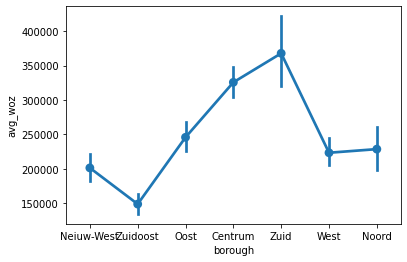

In [37]:
sns.pointplot(data=train, x="borough", y=TARGET, estimator=np.mean)

#### 2- Add % of hh counts by row totals and col totals

In [38]:
# divide house counts by row totals
num_train = train.iloc[:, 1:8]
print(num_train.columns)
row_totals = num_train.div(train["total"], axis=0) * 100
row_totals = row_totals.add_prefix("perc_area_")
row_totals.head()

Index(['single', 'married, no kids', 'not married, no kids',
       'married, with kids', 'not married, with kids', 'single parent',
       'other'],
      dtype='object')


,perc_area_single,"perc_area_married, no kids","perc_area_not married, no kids","perc_area_married, with kids","perc_area_not married, with kids",perc_area_single parent,perc_area_other
174,42.9268,12.0557,8.9895,19.8606,3.7631,9.8258,2.5784
457,56.3536,4.6041,7.5506,6.3229,4.9110,18.9073,1.3505
440,34.5844,5.3619,9.3834,22.5201,10.9920,15.0134,2.1448
297,50.6341,8.1951,9.5122,16.8780,3.3659,10.1951,1.2195
201,32.7635,22.2934,7.4074,21.6524,5.6980,9.0456,1.1396


In [39]:
# divide house counts by col totals
col_totals = num_train.div(num_train.sum(axis=0), axis=1) * 100
col_totals = col_totals.add_prefix("perc_of_tot_fam_type_")
col_totals.head()

,perc_of_tot_fam_type_single,"perc_of_tot_fam_type_married, no kids","perc_of_tot_fam_type_not married, no kids","perc_of_tot_fam_type_married, with kids","perc_of_tot_fam_type_not married, with kids",perc_of_tot_fam_type_single parent,perc_of_tot_fam_type_other
174,0.2906,0.4728,0.2849,0.6160,0.2851,0.3898,0.6652
457,0.4331,0.2050,0.2717,0.2226,0.4224,0.8516,0.3955
440,0.0609,0.0547,0.0773,0.1816,0.2165,0.1548,0.1438
297,0.4898,0.4591,0.4307,0.7478,0.3643,0.5778,0.4495
201,0.2170,0.8553,0.2297,0.6570,0.4224,0.3511,0.2877


In [40]:
# merge row_totals and col_totals before merging into train dataframe
totals = row_totals.merge(col_totals, how="inner", left_index=True, right_index=True)
assert totals.shape[0] == row_totals.shape[0]
assert totals.shape[1] == row_totals.shape[1] * 2
totals.head()

del row_totals, col_totals

In [41]:
train = train.merge(totals, how="inner", left_index=True, right_index=True)
train.shape

(343, 26)

In [42]:
del totals

#### 3- Add features derived from area's name

In [43]:
train["area_lower"] = train["area"].str.lower()

train["area_has_buurt"] = train["area_lower"].str.contains("buurt")
train["area_has_burg"] = train["area_lower"].str.contains("burg")
train["area_has_dijk"] = train["area_lower"].str.contains("dijk")
train["area_has_park"] = train["area_lower"].str.contains("park")
train["area_has_plein"] = train["area_lower"].str.contains("plein")
train["area_has_nieuw"] = train["area_lower"].str.contains("nieuw")
train["area_has_gracht"] = train["area_lower"].str.contains("gracht")
train["area_has_dorp"] = train["area_lower"].str.contains("dorp")

train.drop(columns="area_lower", inplace=True)

In [44]:
for col in train.select_dtypes(include="bool").columns:
    print(f"{col} is True for {train[train[col]==True]['single'].count()} areas")

area_has_buurt is True for 161 areas
area_has_burg is True for 11 areas
area_has_dijk is True for 9 areas
area_has_park is True for 19 areas
area_has_plein is True for 17 areas
area_has_nieuw is True for 10 areas
area_has_gracht is True for 7 areas
area_has_dorp is True for 19 areas


In [45]:
train.shape

(343, 34)

#### 4- Add borough details

In [46]:
# get area per borough and calc housing density
borough_details = pd.read_csv(data / "borough_details.csv")

borough_details["borough"] = borough_details["borough"].replace(
    "Nieuw-West", "Neiuw-West"
)

borough_details.drop(
    columns=["km_sq", "New", "HasBijlmer", "VondelparkProximity", "Museumplein"],
    inplace=True,
)

borough_details.head(8)

,borough,Highest_income_hhs,Touristy,Diversity,HasHomeStadium,IsPosh
0,Centrum,1,1,4,9,3
1,Noord,0,9,9,9,9
2,Neiuw-West,0,9,9,9,9
3,Oost,0,4,1,9,9
4,West,0,2,2,9,2
5,Westpoort,0,4,9,9,9
6,Zuid,1,1,4,9,1
7,Zuidoost,0,4,9,1,9


In [ ]:
# Saving borough details as dicionary for test data transformation
borough_details.to_dict()

In [47]:
train_details = train.merge(borough_details, how="left", on="borough")

<AxesSubplot:xlabel='Highest_income_hhs', ylabel='avg_woz'>

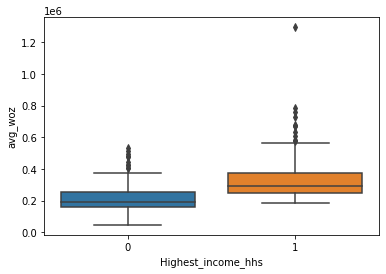

In [48]:
col = "Highest_income_hhs"
sns.boxplot(data=train_details, x=col, y=TARGET)

<AxesSubplot:xlabel='Touristy', ylabel='avg_woz'>

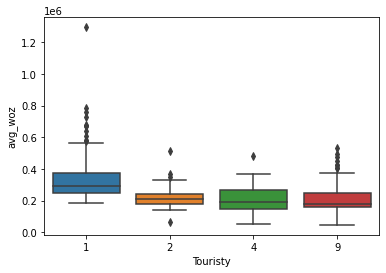

In [49]:
col = "Touristy"
sns.boxplot(data=train_details, x=col, y=TARGET)

<AxesSubplot:xlabel='Diversity', ylabel='avg_woz'>

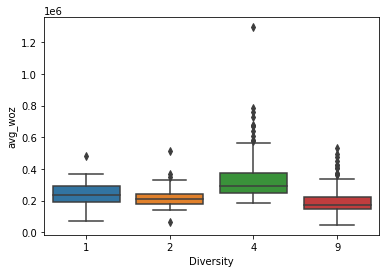

In [50]:
col = "Diversity"
sns.boxplot(data=train_details, x=col, y=TARGET)

<AxesSubplot:xlabel='HasHomeStadium', ylabel='avg_woz'>

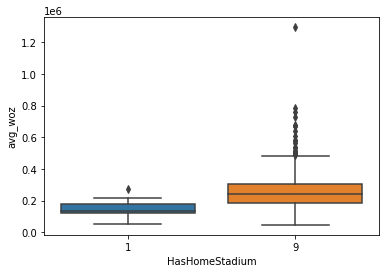

In [51]:
col = "HasHomeStadium"
sns.boxplot(data=train_details, x=col, y=TARGET)

<AxesSubplot:xlabel='IsPosh', ylabel='avg_woz'>

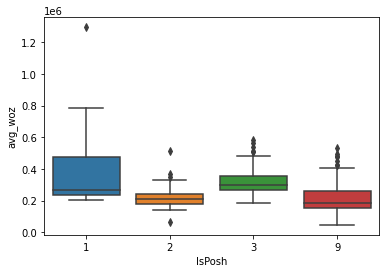

In [52]:
col = "IsPosh"
sns.boxplot(data=train_details, x=col, y=TARGET)

The columns with ordinal values are manually filled using research, with subjective rankings.
This is a shortcut. Ideally, I would take latitudes and longitudes of all areas and get their distances from major landmarks, also from nearest schools, parks, hospitals, tech parks, cultural centers, supermarkets, etc. 
In some cases, distance would make less sense and just presence/no presence kind of feature would.

In [53]:
train_details = train.merge(borough_details, how="left", on="borough")
assert train_details.shape == (
    train.shape[0],
    train.shape[1] + borough_details.shape[1] - 1,
)

In [54]:
train_details.shape

(343, 39)

At this point, the number of columns have exceeded 34, which it should not! We have limited number of rows and we want to maintain row to column ratio as < 10.

Can drop `abs_cols` from modeling and that will be fine

In [55]:
abs_cols

['single',
 'married, no kids',
 'not married, no kids',
 'married, with kids',
 'not married, with kids',
 'single parent',
 'other']

In [56]:
# Also, see the model with and without these columns. This is because the borough name might make up for these additional details.
borough_details = [
    "Highest_income_hhs",
    "Touristy",
    "Diversity",
    "HasHomeStadium",
    "IsPosh",
]

In [57]:
train_details.isnull().sum().sum()

0

In [58]:
output_path = data / "02_intermediate/train_feature_engg.csv"
train_details.to_parquet(output_path, index=None)